# Keras API 와 LSTM 을 이용한 한글 어린왕자 문장 생성기

- next word 예측

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import tensorflow.keras.regularizers as regularizers
import numpy as np 

In [5]:
r = open("datasets/어린왕자-dmsah10.txt", 'r', encoding="cp949")

texts = r.readlines()
lines = []

for line in texts:
    line = line.strip().lower()
    if len(line) == 0:
        continue
    lines.append(line)

text = " ".join(lines)
text[:1000]

'여섯 살 적에 나는 "체험한 이야기"라는 제목의, 원시림에 관한 책에서 기막힌 그림 하나를 본 적이 있다. 맹수를 집어삼키고 있는 보아 구렁이 그림이었다. 위의 그림은 그것을 옮겨 그린 것이다. 그 책에는 이렇게 씌어 있었다. "보아 구렁이는 먹이를 씹지도 않고 통째로 집어삼킨다.그리고는 꼼짝도 하지 못하고 여섯 달 동안 잠을 자면서 그것을 소화시킨다." 나는 그래서 밀림 속에서의 모험에 대해 한참 생각해 보고 난 끝에 색연필을 가지고 내 나름대로 내 생애 첫번째 그림을 그려보았다. 나의 그림 제 1호였다. 그것은 이런 그림이었다. 나는 그 걸작품을 어른들에게 보여 주면서내 그림이 무섭지 않느냐고 물었다. 그들은 "모자가 뭐가 무섭다는 거니?" 하고 대답했다. 내 그림은 모자를 그린 게 아니었다. 그것은 코끼리를 소화시키고 있는 보아 구렁이었다. 그래서 나는 어른들이 알아볼 수 있도록 보아 구렁이의 속을 그렸다. 어른들은 언제나 설명을 해주어야만 한다. 나의 그림 제 2호는 이러했다. 어른들은 속이 보이거나 보이지 않거나 하는 보아 구렁이의 그림들은 집어치우고 차라리 지리, 역사, 계산, 그리고 문법 쪽에 관심을 가져보는 게 좋을 것이라고 충고해 주었다. 그래서 나는 여섯 살 적에 화가라는 멋진 직업을 포기해 버렸다.내 그림제 1호와 제 2호가 성공을 거두지 못한 데 낙심해 버렸던 것이다. 어른들은언제나 스스로는 아무것도 이해하지 못한다.자꾸자꾸 설명을 해주어야 하니 맥빠지는 노릇이 아닐 수 없다. 그래서 다른 직업을 선택하지 않을 수 없게 된 나는 비행기 조종하는 법을배웠다.세계의 여기저기 거의 안 가본 데 없이 나는 날아다녔다.그러니지리는 정말로 많은 도움을 준 셈이었다.한번 슬쩍 보고도 중국과 애리조나를 나는 구별할 수 있었던 것이다.그것은 밤에 길을 잃었을 때 아주 유용한 일이다. 나는 그리하여 일생 동안 수없이 많은 점잖은 사람들과수많은 접촉을 가져왔다.어른들 틈에서 많이 살아온 것이다.나는 가까이서 그들을 볼 수있었다. 그렇다고 해서 그들에 대한 

In [0]:
import re

corpus = re.split('[,.]', text)

In [7]:
corpus[:10]

['여섯 살 적에 나는 "체험한 이야기"라는 제목의',
 ' 원시림에 관한 책에서 기막힌 그림 하나를 본 적이 있다',
 ' 맹수를 집어삼키고 있는 보아 구렁이 그림이었다',
 ' 위의 그림은 그것을 옮겨 그린 것이다',
 ' 그 책에는 이렇게 씌어 있었다',
 ' "보아 구렁이는 먹이를 씹지도 않고 통째로 집어삼킨다',
 '그리고는 꼼짝도 하지 못하고 여섯 달 동안 잠을 자면서 그것을 소화시킨다',
 '" 나는 그래서 밀림 속에서의 모험에 대해 한참 생각해 보고 난 끝에 색연필을 가지고 내 나름대로 내 생애 첫번째 그림을 그려보았다',
 ' 나의 그림 제 1호였다',
 ' 그것은 이런 그림이었다']

In [8]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

4594


In [0]:
# create input sequences using list of tokens
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [10]:
print(len(input_sequences))
input_sequences[:10]

9365


[[142, 245],
 [142, 245, 371],
 [142, 245, 371, 3],
 [142, 245, 371, 3, 1322],
 [142, 245, 371, 3, 1322, 739],
 [142, 245, 371, 3, 1322, 739, 372],
 [142, 245, 371, 3, 1322, 739, 372, 1323],
 [1324, 1325],
 [1324, 1325, 1326],
 [1324, 1325, 1326, 1327]]

In [11]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences

array([[   0,    0,    0, ...,    0,  142,  245],
       [   0,    0,    0, ...,  142,  245,  371],
       [   0,    0,    0, ...,  245,  371,    3],
       ...,
       [   0,    0,    0, ..., 4591, 1139, 4592],
       [   0,    0,    0, ..., 1139, 4592, 4593],
       [   0,    0,    0, ..., 4592, 4593,  525]], dtype=int32)

In [0]:
text_dataset = tf.data.Dataset.from_tensor_slices(input_sequences)

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[-1]
    return input_text, target_text

In [14]:
dataset = text_dataset.map(split_input_target).batch(256, drop_remainder=True)

for input, target in dataset.take(1):
  print(input)
  print()
  print(target)

tf.Tensor(
[[   0    0    0 ...    0    0  142]
 [   0    0    0 ...    0  142  245]
 [   0    0    0 ...  142  245  371]
 ...
 [   0    0    0 ...  128  189 1418]
 [   0    0    0 ...  189 1418 1419]
 [   0    0    0 ...    0    0   23]], shape=(256, 51), dtype=int32)

tf.Tensor(
[ 245  371    3 1322  739  372 1323 1325 1326 1327  207  740   87  126
  143 1329   10  113  373  741  298  144  742  246   13  743   61 1330
   20  744 1331 1332  186 1333 1334  745   43  493  142 1335  299  247
 1336  144 1337   17 1338 1339 1340  114  374  300  167   14 1341 1342
   91   11 1343   11 1344  746  145 1345  207  248 1346  168  741    2
 1347  747  748 1348 1349  749 1350   33  750  751 1351  494   21   28
  298  375  246   26  376  752 1352   10  113 1353    3  495  496    9
 1354  113  497 1355  249  127  498 1356  147  207  248 1357 1358  301
  499   81  753   27  113  497 1359 1360 1361  754 1362 1363 1364  757
   26  758  759 1365  377    3  142  245  371 1366  500  501  502  250
 1367 13

In [15]:
model = Sequential()
model.add(Embedding(total_words, 100))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         459400    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          34048     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 2297)              39049     
_________________________________________________________________
dense_1 (Dense)              (None, 4594)              10557012  
Total params: 11,094,693
Trainable params: 11,094,693
Non-trainable params: 0
____________________________________________

In [22]:
 %%time
 history = model.fit(dataset, epochs=200, verbose=1)

Epoch 1/200
36/36 [==============================] - 3s 72ms/step - loss: 1.2275 - accuracy: 0.7969
Epoch 2/200
36/36 [==============================] - 3s 75ms/step - loss: 1.2111 - accuracy: 0.7979
Epoch 3/200
36/36 [==============================] - 3s 74ms/step - loss: 1.2107 - accuracy: 0.8011
Epoch 4/200
36/36 [==============================] - 3s 74ms/step - loss: 1.2136 - accuracy: 0.7956
Epoch 5/200
36/36 [==============================] - 3s 73ms/step - loss: 1.2084 - accuracy: 0.7964
Epoch 6/200
36/36 [==============================] - 3s 76ms/step - loss: 1.1930 - accuracy: 0.8018
Epoch 7/200
36/36 [==============================] - 3s 73ms/step - loss: 1.1959 - accuracy: 0.8022
Epoch 8/200
36/36 [==============================] - 3s 74ms/step - loss: 1.1880 - accuracy: 0.8025
Epoch 9/200
36/36 [==============================] - 3s 74ms/step - loss: 1.1840 - accuracy: 0.8041
Epoch 10/200
36/36 [==============================] - 3s 80ms/step - loss: 1.1740 - accuracy: 0.8032

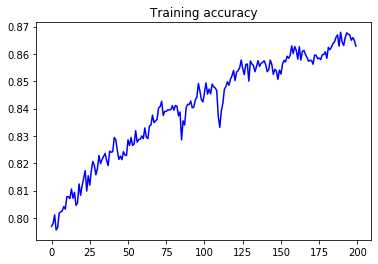

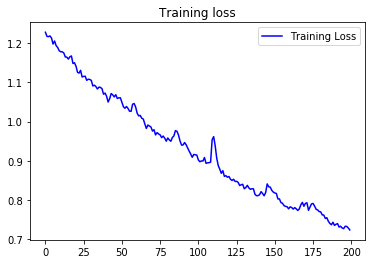

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [24]:
seed_text = "그래서 나는 어른들이 알아볼 수 있도록 보아 구렁이의 속을 그렸다"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = tokenizer.index_word[predicted[0]]
    seed_text += " " + output_word
print(seed_text)

그래서 나는 어른들이 알아볼 수 있도록 보아 구렁이의 속을 그렸다 그렸다 말이다 해냈으면 데라곤 쌓아 움직이는 알 시간이 없어졌어 전부터 꼭 꺼질 수 없는 것이다 이 세상에 오직 하나뿐이 라는 걸 깨닫게 될 거야 거야 이 세상에 있잖아 내가 알게 된 이 세상에 하는 사람인지 알게 된 섭섭했다 세어 싶습니다 큰 바라보았다 옷을 말이다 나쁜 같은 분이 것이다 불이 꺼진 화산이지요 사리에 두드렸다 갖는 않은 계산보다 더 눈에 잠을 양 거지 한 나쁜 하늘을 바라보며 세 잘 보았어요 라고 이 그림을 들여다보았다 이행되는지 그는 말을 알게 되었다 된다 생각했다 발견하면 그건 네 소유가 되는 거고 없었다 일이었다 조금씩 몸이 갖는 것은 나의 명령들이 이치에 맞는 까닭이다 나쁜 초상화를 주고는 줄
